In [1]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pysam
from IPython.display import display

Indexing

`./minimap2 -H reference.fasta -d index.idx` 

Get alignment

`./minimap2 index.idx fastqfile -a --MD --eqx && samtools view -b && samtools sort > align_sorted.bam`

In [35]:
def get_matrix(bam_path):
    
    CIGAR = 'MIDNSHP=XB'
    error_percentage = [0 for i in range(100)]
    nucleotides = ['A', 'T', 'G', 'C']
    matrix = {base: {} for base in nucleotides}
    for i in nucleotides:
        for j in nucleotides:
            matrix[i][j] = 0
            
    with pysam.AlignmentFile(bam_path, 'r') as bam:
        for read in bam.fetch():
            try:
                ref = read.get_reference_sequence()
            except TypeError:
                continue
            query = read.query_sequence
            ref_position = 0
            query_position = 0
            error_count = 0
            for i, s in read.cigartuples:
                op = CIGAR[i]
                if op == 'M':
                    ref_position += s
                    query_position += s
                elif op == 'I':
                    query_position += s
                    error_count += s
                elif op == 'D':
                    ref_position += s
                    error_count += s
                elif op == 'N':
                    ref_position += s
                elif op == 'S':
                    query_position += s
                elif op in 'HP':
                    pass
                elif op == '=':
                    query_position += s
                    ref_position += s
                elif op == 'X':
                    for i in range(s):
                        refb = ref[ref_position + i].upper() 
                        queryb = query[query_position + i].upper()
                        matrix[refb][queryb] += 1
                    ref_position += s
                    query_position += s
                    error_count += s
                
            read_length = len(read.query_sequence)
            error_percent = round(100*error_count / read_length)
            error_percentage[error_percent] += 1
    
    TOT, n_reads = 0, 0 
    for i, c in enumerate(error_percentage):
        n_reads += c
        percent = i + 1
        TOT += percent * c
    print(f'Mean error percent: {TOT / n_reads}%')
    print('\n======Substitution matrix=====')
    display(pd.DataFrame(matrix))

In [30]:
def get_indels(bam_path):
    
    with pysam.AlignmentFile(bam_path, 'r') as bam:
        
        CIGAR = 'MIDNSHP=XB'
        ID_size_dict = defaultdict(int)
        
        for read in bam.fetch():
            if read.cigartuples:
                for i, s in read.cigartuples:
                    if CIGAR[i] == 'I' or CIGAR[i] == 'D':
                        ID_size_dict[s] += 1
        
        x = sorted(list(ID_size_dict.keys()))
        y = [ID_size_dict[i] for i in x]
        
        for size, number in zip(x, y):
            print(f'{number} indels with lentgh={size}')

In [31]:
def get_coverage(bam_path):
    
    with pysam.AlignmentFile(bam_path, 'r') as bam:
        
        Ref_len = bam.lengths[0]
        Coverage = [0 for i in range(Ref_len)]
        
        for c in bam.pileup():
            Coverage[c.pos] = c.n
            
    print(f'Mean coverage: {sum(Coverage)/Ref_len}')
    
    Coverage_1000 = [np.mean(np.array(Coverage[i:i+1000])) for i in range(0, Ref_len, 1000)]
    plt.figure(figsize=(10, 10))
    plt.bar([i for i in range(len(Coverage_1000))], Coverage_1000)
    plt.ylabel('Coverage')
    plt.xlabel('pos')
    plt.show()

# PacBio

In [33]:
pac_bio = '/home/alex/works/NGS_3/minimap2/pb_sorted.bam'

Mean coverage: 40.42479591781752


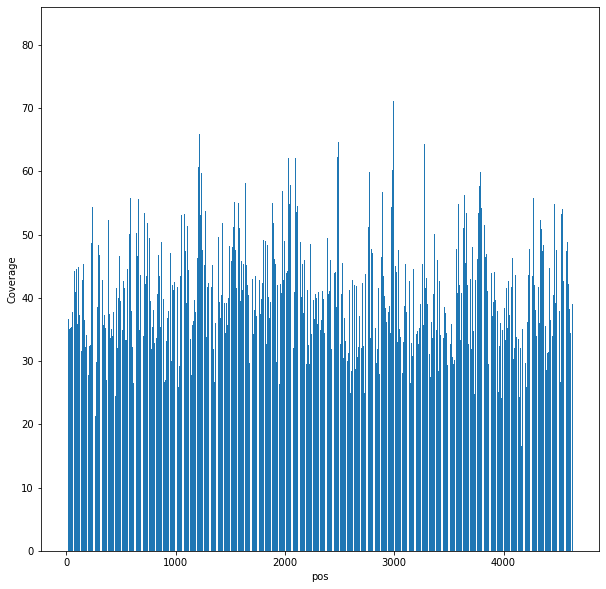

In [34]:
get_coverage(pac_bio)

In [36]:
get_matrix(pac_bio)

Mean error percent: 14.448322120775268%

======Substitution matrix=====


,A,T,G,C
A,0,297966,336400,472949
T,298040,0,465451,336348
G,318086,371399,0,427585
C,365944,320204,429322,0


In [37]:
get_indels(pac_bio)

13459949 indels with lentgh=1
2491549 indels with lentgh=2
688037 indels with lentgh=3
275626 indels with lentgh=4
139459 indels with lentgh=5
78133 indels with lentgh=6
49306 indels with lentgh=7
31745 indels with lentgh=8
21465 indels with lentgh=9
15363 indels with lentgh=10
10742 indels with lentgh=11
7867 indels with lentgh=12
5817 indels with lentgh=13
4354 indels with lentgh=14
3303 indels with lentgh=15
2533 indels with lentgh=16
1821 indels with lentgh=17
1394 indels with lentgh=18
1010 indels with lentgh=19
752 indels with lentgh=20
839 indels with lentgh=21
905 indels with lentgh=22
876 indels with lentgh=23
890 indels with lentgh=24
817 indels with lentgh=25
769 indels with lentgh=26
765 indels with lentgh=27
747 indels with lentgh=28
668 indels with lentgh=29
630 indels with lentgh=30
596 indels with lentgh=31
528 indels with lentgh=32
503 indels with lentgh=33
493 indels with lentgh=34
440 indels with lentgh=35
377 indels with lentgh=36
433 indels with lentgh=37
365 indel

# Oxford Nanopores

In [38]:
onp = '/home/alex/works/NGS_3/minimap2/np_sorted.bam'

Mean coverage: 28.010522073205557


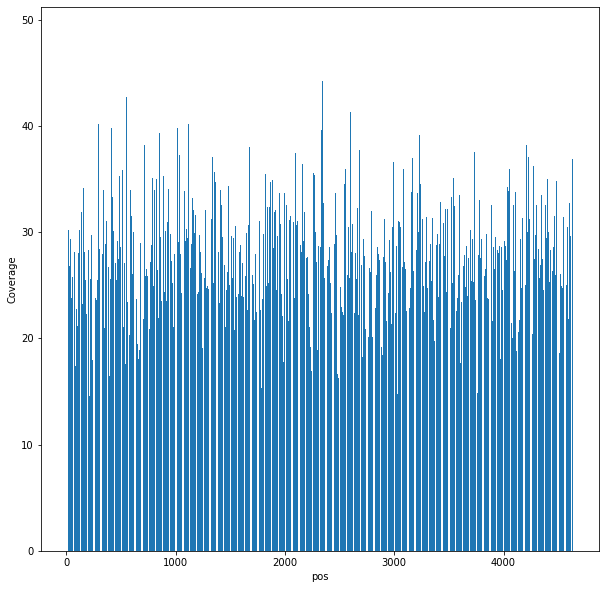

In [39]:
get_coverage(onp)

In [40]:
get_matrix(onp)

Mean error percent: 9.028428034955954%

======Substitution matrix=====


,A,T,G,C
A,0,107765,319761,137046
T,105373,0,126487,340675
G,368487,111447,0,85027
C,112963,372780,91353,0


In [41]:
get_indels(onp)

2457627 indels with lentgh=1
981772 indels with lentgh=2
456831 indels with lentgh=3
180343 indels with lentgh=4
87636 indels with lentgh=5
49534 indels with lentgh=6
26388 indels with lentgh=7
15815 indels with lentgh=8
10734 indels with lentgh=9
6528 indels with lentgh=10
3991 indels with lentgh=11
2936 indels with lentgh=12
1788 indels with lentgh=13
1164 indels with lentgh=14
904 indels with lentgh=15
598 indels with lentgh=16
383 indels with lentgh=17
263 indels with lentgh=18
205 indels with lentgh=19
139 indels with lentgh=20
114 indels with lentgh=21
122 indels with lentgh=22
101 indels with lentgh=23
84 indels with lentgh=24
74 indels with lentgh=25
61 indels with lentgh=26
58 indels with lentgh=27
52 indels with lentgh=28
30 indels with lentgh=29
32 indels with lentgh=30
37 indels with lentgh=31
40 indels with lentgh=32
29 indels with lentgh=33
31 indels with lentgh=34
23 indels with lentgh=35
20 indels with lentgh=36
18 indels with lentgh=37
12 indels with lentgh=38
13 indel

Покрытие в целом колеблется от 25 до 50 для обоих секвенаторов, что не очень много. Много инделов, особенно у PacBio. Сильно больше ошибок в сравненни с illuminf и IonTorrent. 